In [94]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

$\pi$ aproximation using Monte Carlo method

In [73]:
def random_point_two_rands(
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float
    ) -> tuple[float, float]:

    x = random.random() * (x_max - x_min) + x_min
    y = random.random() * (y_max - y_min) + y_min

    return (x,y)

def random_point_one_rand(
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float
    ) -> tuple[float]:
    
    x = random.random() * (x_max - x_min) + x_min
    y = f(x)

    return (x,y)

Different methods to generate random points

In [74]:
def generate_points_general(
        n: int, 
        layers_n: int,
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float,
        rand_point_fun: callable
    ) -> list[tuple[float, float]]:

    points = []
    layers = []
    for _ in range(n):
        point = rand_point_fun(x_min, x_max, y_min, y_max, f)
        points.append(point)

    return points, layers

def generate_points_stratified(
        n: int, 
        layers_n: int,
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float,
        rand_point_fun: callable
    ) -> list[tuple[float, float]]:

    n_per_layer = n // layers_n
    points = []
    layers = []

    for i in range(layers_n):
        curr_x_min = x_min + i * (x_max - x_min) / layers_n
        curr_x_max = x_min + (i + 1) * (x_max - x_min) / layers_n
        layers.append(curr_x_max)
        
        for _ in range(n_per_layer):
            point = rand_point_fun(curr_x_min, curr_x_max, y_min, y_max, f)
            points.append(point)
    
    return points, layers[:-1]

def generate_points_antithetic(
        n: int, 
        layers_n: int,
        x_min: float, x_max: float, 
        y_min: float, y_max: float,
        f: lambda float: float,
        rand_point_fun: callable
    ) -> list[tuple[float, float]]:
    
    if n % 2 != 0:
        raise ValueError("Number of points must be even for antithetic sampling.")
    
    n_per_layer = n // layers_n // 2
    
    points = []
    layers = []
    for i in range(layers_n):
        curr_x_min = x_min + i * (x_max - x_min) / layers_n
        curr_x_max = x_min + (i + 1) * (x_max - x_min) / layers_n
        layers.append(curr_x_max)

        for _ in range(n_per_layer):
            point1 = rand_point_fun(curr_x_min, curr_x_max, y_min, y_max, f)
            points.append(point1)

            sym_x = curr_x_max - (point1[0] - curr_x_min)

            point2 = rand_point_fun(sym_x, sym_x, y_min, y_max, f)
            points.append(point2)

    return points, layers[:-1]

Calculate $\pi$ approximation using:
* ratio of points under the curve to total points
* average of function values for points


In [75]:
def sample_2d(
        x_min: float, x_max: float, 
        y_min: float, y_max: float, 
        fun: lambda float: float,
        points: list[tuple[float, float]], 
    ) -> float:

    n = len(points)
    inside = 0
    for point in points:
        if fun(point[0]) >= point[1]:
            inside += 1

    area = (x_max - x_min) * (y_max - y_min)
    approximation = (inside / n) * area

    return approximation

def sample_1d(
    x_min: float, x_max: float,
    y_min: float, y_max: float,
    fun: lambda float: float,
    points: list[tuple[float, float]],
) -> float:
    
    n = len(points)
    approximation = sum(point[1] for point in points) * (x_max - x_min) / n

    return approximation

Visualisation of the points

In [76]:
def visualise(points: list[tuple[float, float]], layers: list[float], subtitle: str) -> None:
    _, ax = plt.subplots()

    outer_square = patches.Rectangle(
        (0, 0),
        width=1, height=1,
        edgecolor="green", facecolor="none",
        linewidth=1
    )
    ax.add_patch(outer_square)

    inner_square = patches.Rectangle(
        (0, 0),
        width=math.sqrt(2)/2, height=math.sqrt(2)/2,
        edgecolor="blue", facecolor="none",
        linewidth=1
    )
    ax.add_patch(inner_square)

    quarter_circle = patches.Wedge(
        center=(0, 0),
        r=1, theta1=0, theta2=90,
        edgecolor="blue", facecolor="none",
        linewidth=1
    )
    ax.add_patch(quarter_circle)

    for layer in layers:
        ax.axvline(x=layer, color="red", linestyle="--", linewidth=0.5)

    for point in points:
        ax.plot(point[0], point[1], "o", color="blue" if (point[0]**2 + point[1]**2 <= 1 ) else "green")

    ax.set_aspect("equal", "box")
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    plt.suptitle(r"$\pi$ approximation")
    plt.title(subtitle)
    plt.show()

Sampling whole square [0,1]x[0,1]

In [77]:
def approximate_whole_square(
        n: int, layers_n: int,
        sampling_method: callable,
        single_point_generation: callable, 
        all_points_generation: callable, 
        draw: bool, subtitle: str
    ) -> tuple[float, float]:

    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    f = lambda x: math.sqrt(1 - x**2)

    points, layers = all_points_generation(
        n, layers_n,
        x_min, x_max,
        y_min, y_max,
        f, single_point_generation
    )

    approximation = sampling_method(x_min, x_max, y_min, y_max, lambda x: math.sqrt(1 - x**2), points)
    area = 4 * approximation
    variance = (area - math.pi) ** 2

    if draw:
        visualise(points, layers, subtitle)

    return area, variance

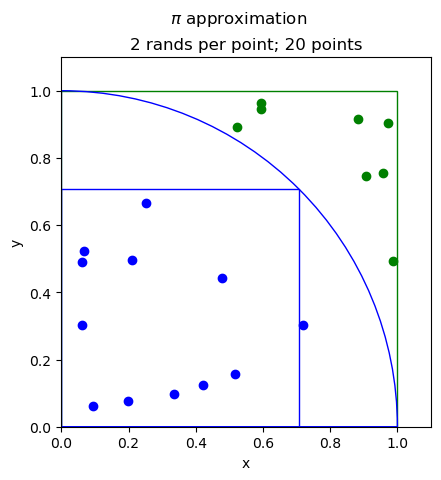

(2.4, 0.549959663858351)
(3.140124, 2.1569433668118028e-06)


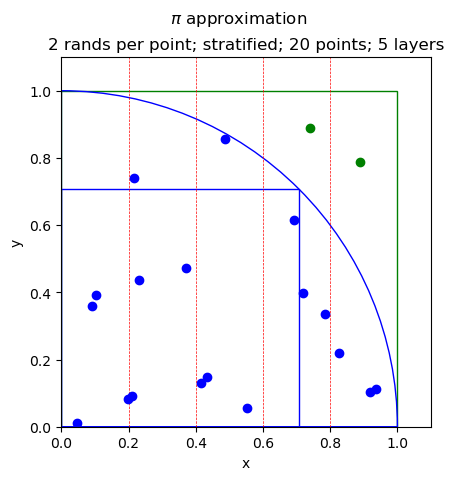

(3.6, 0.2101372952428475)
(3.142256, 4.4002845993457203e-07)


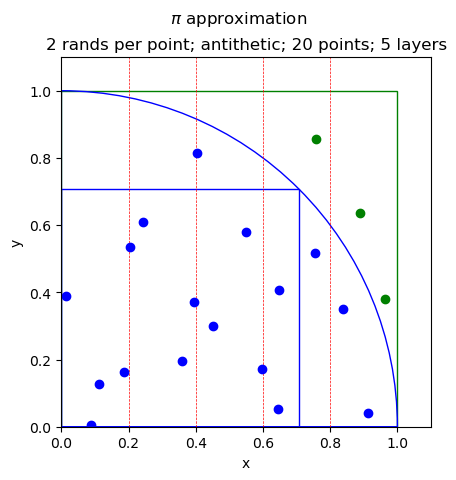

(3.4, 0.06677435667876462)
(3.140956, 4.0532779339635777e-07)


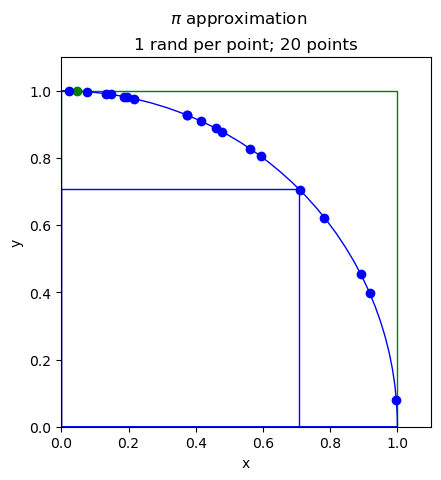

(3.267551253398061, 0.015865568865659346)
(3.1405876639123464, 1.0100042517743538e-06)


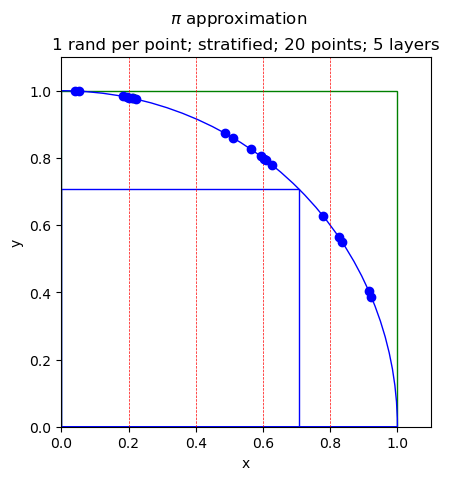

(3.227613725385531, 0.007399624792887498)
(3.1414676876881016, 1.5616476585577556e-08)


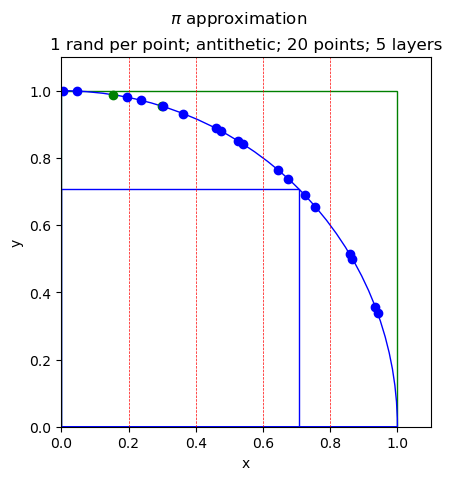

(3.1586258994020655, 0.00029013146290129494)
(3.1416679691207503, 5.672429203363046e-09)


In [78]:
POINTS_NUM_TO_DRAW = 20
POINTS_NUM_TO_CALC = 1000000
LAYERS_NUM = 5

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, None, 
    sample_2d, random_point_two_rands, generate_points_general, True, f"2 rands; {POINTS_NUM_TO_DRAW} points"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, None, 
    sample_2d, random_point_two_rands, generate_points_general, False, None
))

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_stratified, True, f"2 rands; stratified; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_stratified, False, None
))

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_antithetic, True, f"2 rands; antithetic; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_antithetic, False, None
))

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, None, 
    sample_1d, random_point_one_rand, generate_points_general, True, f"1 rand; {POINTS_NUM_TO_DRAW} points"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, None, 
    sample_1d, random_point_one_rand, generate_points_general, False, None
))

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_stratified, True, f"1 rand; stratified; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_stratified, False, None
))

print(approximate_whole_square(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_antithetic, True, f"1 rand; antithetic; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_whole_square(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_antithetic, False, None
))


Sampling only irregular parts 

In [79]:
def approximate_only_irregular_parts(
        n: int, layers_n: int,
        sampling_method: callable,
        single_point_generation: callable, 
        all_points_generation: callable, 
        draw: bool, subtitle: str
    ) -> tuple[float, float]:

    x_min, x_max = math.sqrt(2) / 2, 1
    y_min, y_max = 0, math.sqrt(2) / 2
    f = lambda x: math.sqrt(1 - x**2)

    points, layers = all_points_generation(
        n, layers_n,
        x_min, x_max,
        y_min, y_max,
        f, single_point_generation
    )

    approximation = sampling_method(x_min, x_max, y_min, y_max, lambda x: math.sqrt(1 - x**2), points)
    area = 4 * (1/2 + 2 * approximation)
    variance = (area - math.pi) ** 2

    if draw:
        visualise(points, layers, subtitle)

    return area, variance

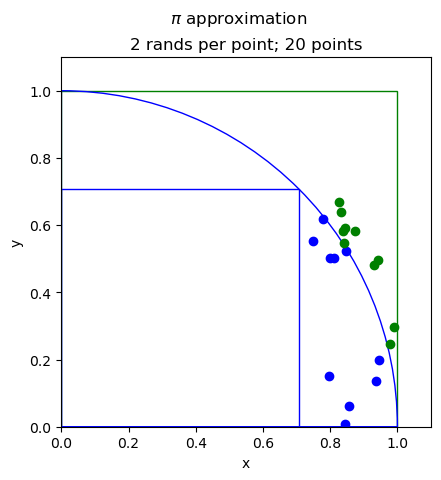

(2.82842712474619, 0.09807264845589371)
(3.1409479438481913, 4.156506509162611e-07)


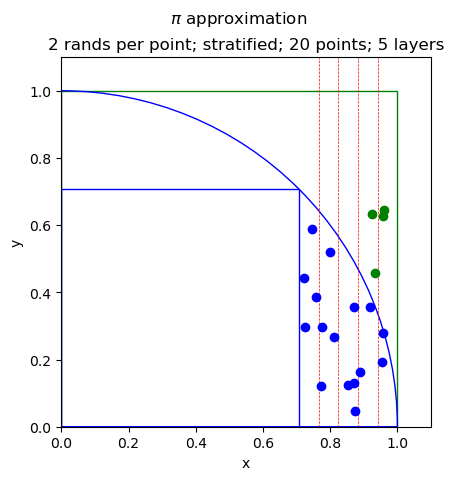

(3.325483399593904, 0.033815806465948395)
(3.1406944451480188, 8.067784048747073e-07)


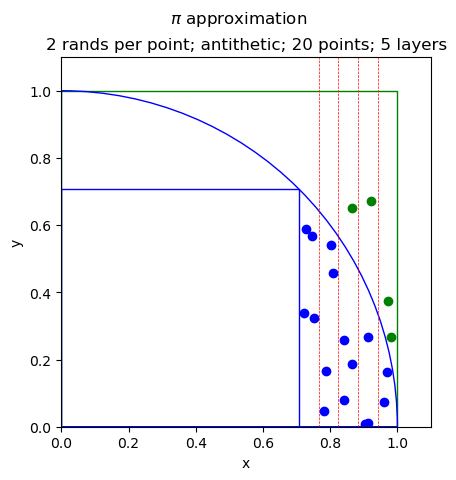

(3.325483399593904, 0.033815806465948395)
(3.1418443019971667, 6.332692093365551e-08)


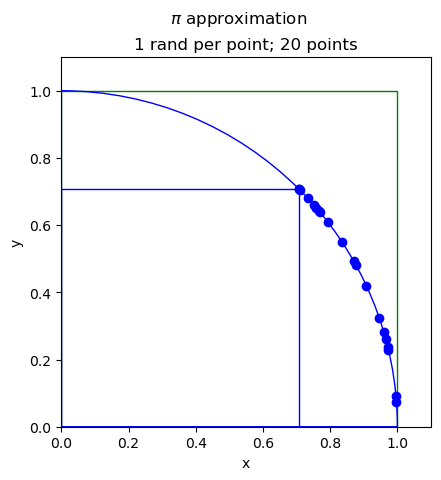

(3.1057932895469933, 0.0012815944658689086)
(3.1420439097688377, 2.0363213912595325e-07)


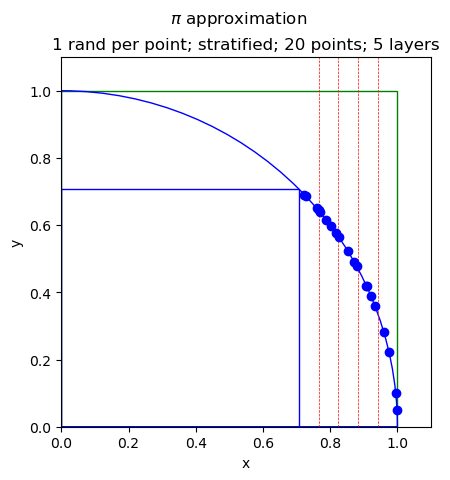

(3.100325980961953, 0.0017029382697733104)
(3.141458045651212, 1.8119297129115803e-08)


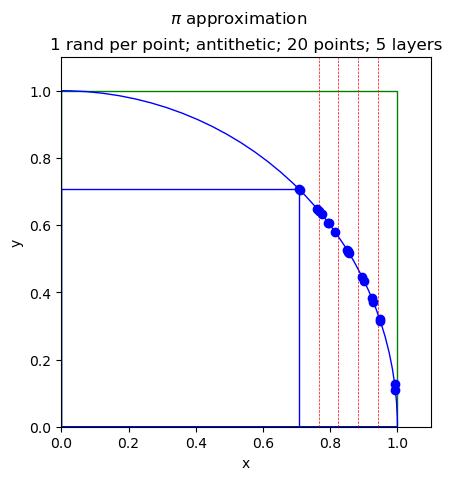

(3.137990777043206, 1.2973514656853905e-05)
(3.1415476954633332, 2.0212331347827378e-09)


In [80]:
POINTS_NUM_TO_DRAW = 20
POINTS_NUM_TO_CALC = 1000000
LAYERS_NUM = 5

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, None, 
    sample_2d, random_point_two_rands, generate_points_general, True, f"2 rands; {POINTS_NUM_TO_DRAW} points"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, None, 
    sample_2d, random_point_two_rands, generate_points_general, False, None
))

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_stratified, True, f"2 rands; stratified; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_stratified, False, None
))

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_antithetic, True, f"2 rands; antithetic; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_2d, random_point_two_rands, generate_points_antithetic, False, None
))

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, None, 
    sample_1d, random_point_one_rand, generate_points_general, True, f"1 rand; {POINTS_NUM_TO_DRAW} points"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, None, 
    sample_1d, random_point_one_rand, generate_points_general, False, None
))

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_stratified, True, f"1 rand; stratified; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_stratified, False, None
))

print(approximate_only_irregular_parts(
    POINTS_NUM_TO_DRAW, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_antithetic, True, f"1 rand; antithetic; {POINTS_NUM_TO_DRAW} points; {LAYERS_NUM} layers"
))
print(approximate_only_irregular_parts(
    POINTS_NUM_TO_CALC, LAYERS_NUM, 
    sample_1d, random_point_one_rand, generate_points_antithetic, False, None
))

In [109]:
POINT_NUMS = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
LAYERS_NUM = 2
REPS = 10

results = {
    f"whole square; general; 2 rands": [],
    f"whole square; stratified; 2 rands; {LAYERS_NUM} layers": [],
    f"whole square; antithetic; 2 rands; 1 layer": [],
    f"whole square; general; 1 rand": [],
    f"whole square; stratified; 1 rand; {LAYERS_NUM} layers": [],
    f"whole square; antithetic; 1 rand; 1 layer": [],
    f"irregular parts; general; 2 rands": [],
    f"irregular parts; stratified; 2 rands; {LAYERS_NUM} layers": [],
    f"irregular parts; antithetic; 2 rands; 1 layer": [],
    f"irregular parts; general; 1 rand": [],
    f"irregular parts; stratified; 1 rand; {LAYERS_NUM} layers": [],
    f"irregular parts; antithetic; 1 rand; 1 layer": [],
}

for points_num in POINT_NUMS:
    for method in results.keys():
        results[method].append([0,0])

    for _ in range(REPS):
        res = approximate_whole_square(
            points_num, LAYERS_NUM, sample_2d, random_point_two_rands, generate_points_general, False, None
        )
        results[f"whole square; general; 2 rands"][-1][0] += res[0]
        results[f"whole square; general; 2 rands"][-1][1] += res[1]

        res = approximate_whole_square(
            points_num, LAYERS_NUM, sample_2d, random_point_two_rands, generate_points_stratified, False, None
        )
        results[f"whole square; stratified; 2 rands; {LAYERS_NUM} layers"][-1][0] += res[0]
        results[f"whole square; stratified; 2 rands; {LAYERS_NUM} layers"][-1][1] += res[1]

        res = approximate_whole_square(
            points_num, 1, sample_2d, random_point_two_rands, generate_points_antithetic, False, None
        )
        results[f"whole square; antithetic; 2 rands; 1 layer"][-1][0] += res[0]
        results[f"whole square; antithetic; 2 rands; 1 layer"][-1][1] += res[1]

        res = approximate_whole_square(
            points_num, LAYERS_NUM, sample_1d, random_point_one_rand, generate_points_general, False, None
        )
        results[f"whole square; general; 1 rand"][-1][0] += res[0]
        results[f"whole square; general; 1 rand"][-1][1] += res[1]

        res = approximate_whole_square(
            points_num, LAYERS_NUM, sample_1d, random_point_one_rand, generate_points_stratified, False, None
        )
        results[f"whole square; stratified; 1 rand; {LAYERS_NUM} layers"][-1][0] += res[0]
        results[f"whole square; stratified; 1 rand; {LAYERS_NUM} layers"][-1][1] += res[1]

        res = approximate_whole_square(
            points_num, 1, sample_1d, random_point_one_rand, generate_points_antithetic, False, None
        )
        results[f"whole square; antithetic; 1 rand; 1 layer"][-1][0] += res[0]
        results[f"whole square; antithetic; 1 rand; 1 layer"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, LAYERS_NUM, sample_2d, random_point_two_rands, generate_points_general, False, None
        )
        results[f"irregular parts; general; 2 rands"][-1][0] += res[0]
        results[f"irregular parts; general; 2 rands"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, LAYERS_NUM, sample_2d, random_point_two_rands, generate_points_stratified, False, None
        )
        results[f"irregular parts; stratified; 2 rands; {LAYERS_NUM} layers"][-1][0] += res[0]
        results[f"irregular parts; stratified; 2 rands; {LAYERS_NUM} layers"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, 1, sample_2d, random_point_two_rands, generate_points_antithetic, False, None
        )
        results[f"irregular parts; antithetic; 2 rands; 1 layer"][-1][0] += res[0]
        results[f"irregular parts; antithetic; 2 rands; 1 layer"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, LAYERS_NUM, sample_1d, random_point_one_rand, generate_points_general, False, None
        )
        results[f"irregular parts; general; 1 rand"][-1][0] += res[0]
        results[f"irregular parts; general; 1 rand"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, LAYERS_NUM, sample_1d, random_point_one_rand, generate_points_stratified, False, None
        )
        results[f"irregular parts; stratified; 1 rand; {LAYERS_NUM} layers"][-1][0] += res[0]
        results[f"irregular parts; stratified; 1 rand; {LAYERS_NUM} layers"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            points_num, 1, sample_1d, random_point_one_rand, generate_points_antithetic, False, None
        )
        results[f"irregular parts; antithetic; 1 rand; 1 layer"][-1][0] += res[0]
        results[f"irregular parts; antithetic; 1 rand; 1 layer"][-1][1] += res[1]


    for method in results.keys():
        results[method][-1][0] /= REPS
        results[method][-1][1] /= REPS

with open("zad12.1.pkl", "wb") as f:
    pickle.dump(results, f)

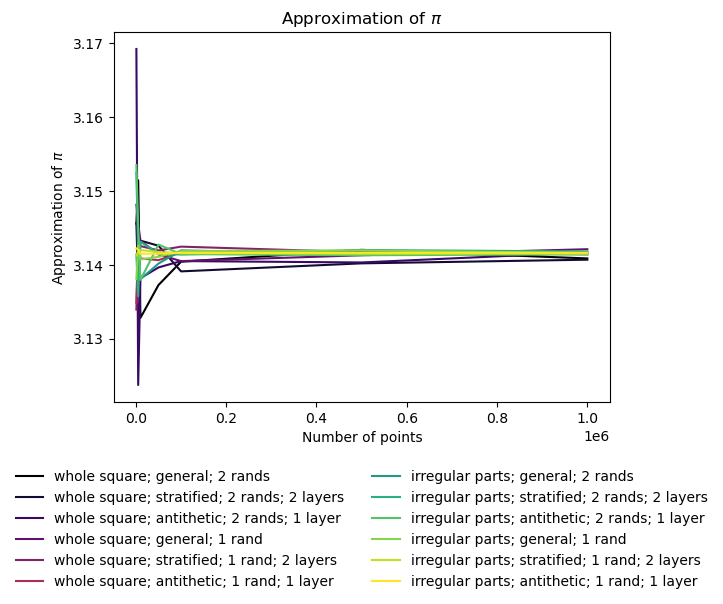

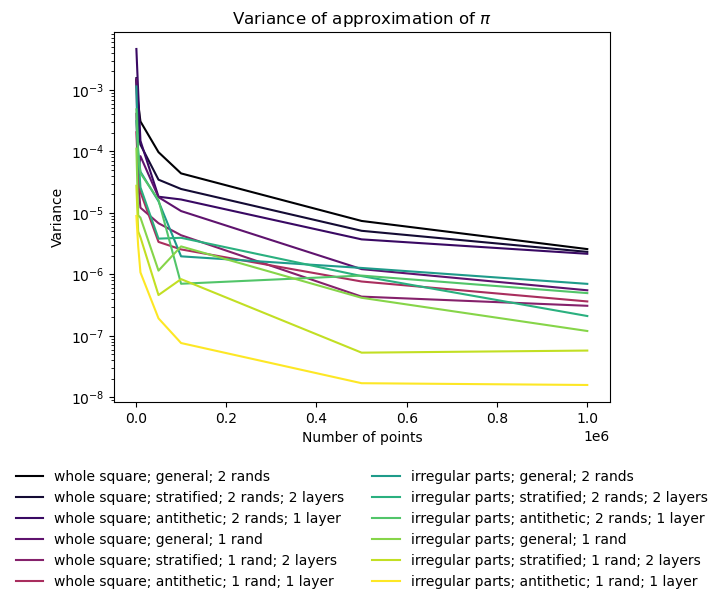

In [122]:
with open("zad12.1.pkl", "rb") as f:
    results = pickle.load(f)

colors = list(plt.cm.inferno(np.linspace(0, 1, 12)))[:6] + list(plt.cm.viridis(np.linspace(0, 1, 12)))[6:]

for index, key_value in enumerate(results.items()):
    key, value = key_value
    plt.plot(POINT_NUMS, [v[0] for v in value], label=key, color=colors[index])
plt.xlabel("Number of points")
plt.ylabel(r"Approximation of $\pi$")
plt.title(r"Approximation of $\pi$")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)
plt.show()

for index, key_value in enumerate(results.items()):
    key, value = key_value
    plt.plot(POINT_NUMS, [v[1] for v in value], label=key, color=colors[index])
plt.xlabel("Number of points")
plt.ylabel(r"Variance")
plt.title(r"Variance of approximation of $\pi$")
plt.yscale("log")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)
plt.show()

In [130]:
POINTS_NUM = 1000000
LAYERS_NUMS = [1, 2, 4, 8, 16, 32]
REPS = 10

results = {
    f"irregular parts; stratified; 1 rand": [],
    f"irregular parts; antithetic; 1 rand": [],
}

for layers_num in LAYERS_NUMS:
    for method in results.keys():
        results[method].append([0,0])

    for _ in range(REPS):
        res = approximate_only_irregular_parts(
            POINTS_NUM, layers_num, sample_1d, random_point_one_rand, generate_points_stratified, False, None
        )
        results[f"irregular parts; stratified; 1 rand"][-1][0] += res[0]
        results[f"irregular parts; stratified; 1 rand"][-1][1] += res[1]

        res = approximate_only_irregular_parts(
            POINTS_NUM, layers_num, sample_1d, random_point_one_rand, generate_points_antithetic, False, None
        )
        results[f"irregular parts; antithetic; 1 rand"][-1][0] += res[0]
        results[f"irregular parts; antithetic; 1 rand"][-1][1] += res[1]

    for method in results.keys():
        results[method][-1][0] /= REPS
        results[method][-1][1] /= REPS

with open("zad12.2.pkl", "wb") as f:
    pickle.dump(results, f)

{'irregular parts; stratified; 1 rand': [[3.141553017959395, 1.4270250216487245e-07], [3.141516043107031, 3.232335956638442e-08], [3.1415648582585023, 6.078125254981585e-09], [3.141620680136344, 4.953572539383596e-09], [3.1415979756211643, 9.264565949125126e-10], [3.141593256372997, 3.7275756664617635e-10]], 'irregular parts; antithetic; 1 rand': [[3.141594462326625, 2.97110569443237e-08], [3.1415906121167767, 3.878075833255146e-09], [3.1416072099416406, 1.6058625990112605e-09], [3.141588268577847, 1.3516384491990042e-10], [3.1415954287967534, 3.94721050578107e-11], [3.141593084635031, 1.6407698459829603e-11]]}


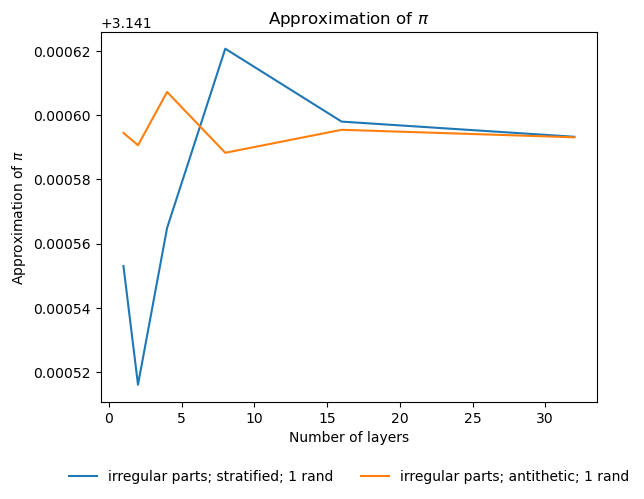

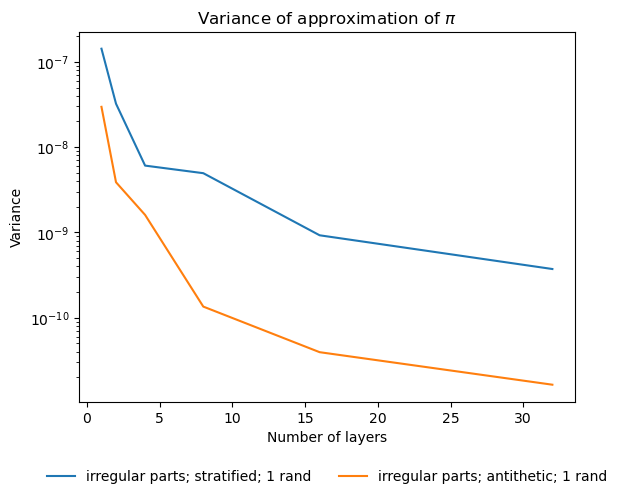

In [132]:
with open("zad12.2.pkl", "rb") as f:
    results = pickle.load(f)

print(results)

for index, key_value in enumerate(results.items()):
    key, value = key_value
    plt.plot(LAYERS_NUMS, [v[0] for v in value], label=key)
plt.xlabel("Number of layers")
plt.ylabel(r"Approximation of $\pi$")
plt.title(r"Approximation of $\pi$")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)
plt.show()

for index, key_value in enumerate(results.items()):
    key, value = key_value
    plt.plot(LAYERS_NUMS, [v[1] for v in value], label=key)
plt.xlabel("Number of layers")
plt.ylabel(r"Variance")
plt.title(r"Variance of approximation of $\pi$")
plt.yscale("log")
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)
plt.show()